In [1]:
import numpy as np
samp_v=np.loadtxt('Isolated_samples_154.txt')

In [3]:
# --- 参数 ---
N_SAMP = 1000             # 每个源的样本数
V_MAX_CAP = 10000.0       # 速度上限 (km/s)

# 假设 samp_v 已经加载，我们获取总样本数
TOTAL_SAMPLES = len(samp_v)
N_STARS = int(TOTAL_SAMPLES / N_SAMP)
rng = np.random.default_rng(123456)

# 最终存储被接受的 V_3D 样本的数组
V_3D_accepted = np.zeros(TOTAL_SAMPLES)
k = 0 # V_3D_accepted 数组的计数器

print(f"--- 启动拒绝采样，目标 V_3D < {V_MAX_CAP:.0f} km/s ---")

# 外层循环：遍历每个源 (465 个)
for i in range(N_STARS):
    
    # 提取当前源的 1000 个固定的 v_trans 样本
    v_trans_samples = samp_v[i * N_SAMP : (i + 1) * N_SAMP]
    # 内层循环：遍历当前源的 1000 个固定 v_trans 样本
    for j in range(N_SAMP):
        v_trans_j = v_trans_samples[j] # 当前固定的 v_trans 值
        
        # 拒绝采样循环：持续生成角度，直到满足 V_MAX_CAP
        while True:
            # 1. 随机采样一个新的 cos(theta) (实现各向同性)
            cos_theta = rng.uniform(-1.0, 1.0)
            
            # 2. 计算 sin(theta)
            sin_theta = np.sqrt(1.0 - cos_theta**2)
            
            # 3. 计算试探 V_3D 值 (添加极小值保护，防止 sin_theta 严格为 0)
            sin_theta = np.maximum(sin_theta, 1e-10) 
            V_3D_trial = v_trans_j / sin_theta
            
            # 4. 验收条件
            if V_3D_trial < V_MAX_CAP:
                # 样本被接受，存储结果，并退出 while 循环
                V_3D_accepted[k] = V_3D_trial
                k += 1
                break
            # 否则 (V_3D_trial >= V_MAX_CAP)，继续 while 循环，重新采样 cos(theta)
    
    # 可选：打印进度
    if (i + 1) % 100 == 0:
        print(f"  已处理 {i + 1}/{N_STARS} 个源...")

print("\n拒绝采样完成。")
print(f"最终生成的 V_3D 最大值: {np.max(V_3D_accepted):.2f} km/s")

# 最终使用的数组是 V_3D_accepted

--- 启动拒绝采样，目标 V_3D < 10000 km/s ---
  已处理 100/154 个源...

拒绝采样完成。
最终生成的 V_3D 最大值: 9972.83 km/s


(0.0, 1000.0)

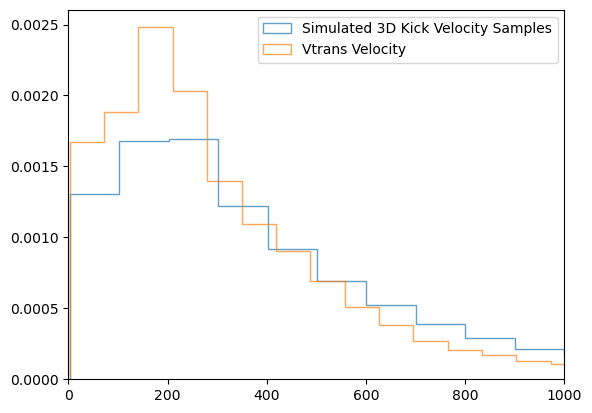

In [4]:
import matplotlib.pyplot as plt
plt.hist(V_3D_accepted,bins=100,density=True,alpha=0.7,histtype='step',label='Simulated 3D Kick Velocity Samples')
plt.hist(samp_v,bins=100,density=True,alpha=0.7,histtype='step',label='Vtrans Velocity')
plt.legend()
plt.xlim(0,1000)

In [ ]:
np.savetxt('samp_v_isolated_154_3D.txt',V_3D_accepted)
print(min(samp_v_new),max(samp_v_new))

2.594940358883912 9972.830032073207


In [1]:
import numpy as np
samp_v_new=np.loadtxt('samp_v_isolated_154_3D.txt')

In [2]:
import numpy as np
from scipy.special import erf
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
import bilby
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from bilby.core.prior import Uniform
from bilby.core.sampler import run_sampler
from bilby.core.prior import LogUniform
from bilby.hyper.likelihood import HyperparameterLikelihood
from scipy import interpolate
from scipy import integrate
import random
import argparse
import os
import glob
import warnings
warnings.filterwarnings("ignore")
#####################
outdir='/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
data_exp=samp_v_new
import sys
#import utilizes
npool=100
NN=int(len(data_exp)/1000)
nlive=800
mx=1000
#################################
data_df=list()
ns_m=abs(data_exp)
for i in range(NN):
    re=pd.DataFrame(ns_m[i*mx:(i+1)*mx],columns=['mu'])
    data_df.append(re)
samples = data_df

def run_prior(dataset):
    return 1/2600



In [ ]:
import numpy as np
import dynesty
from dynesty import plotting as dyplot
from multiprocessing import Pool
import contextlib

# --- 1. 数据加载与筛选 ---
base_path = '/home/lz/work/pulsar_kick_velocity/'
v_obs = np.loadtxt(base_path + 'vtrans_88_data.txt')
p_obs = np.loadtxt(base_path + 'period_88_data.txt')
# 筛选 P > 0.1s
mask = p_obs > 0.1
v_obs, p_obs = v_obs[mask], p_obs[mask]

# 常量 (单位: M_sun, km)
M_NS = 1.4 
I_NS = 50.0

# --- 2. 定义先验和似然 (需在顶级作用域以便 pickling) ---
def prior_transform(u):
    v = np.array(u)
    v[0] = u[0] * 10.0                 # R_kick: [0, 10] km
    v[1] = np.arccos(1.0 - 2.0 * u[1])  # alpha (各向同性)
    v[2] = np.arccos(1.0 - 2.0 * u[2])  # beta (各向同性)
    v[3] = np.arccos(1.0 - 2.0 * u[3])  # gamma (各向同性)
    v[4] = u[4] * 1.0                  # P_birth: [0, 1] s
    v[5] = u[5] * 1.0                  # tau_tilde: [0, 1]
    return v

def log_likelihood(theta):
    R_kick, alpha, beta, gamma, P_birth, tau_tilde = theta
    
    # 防止除零
    sb = np.sin(beta)
    if sb <= 0: return -1e30
    
    # 物理模型计算 (单位保持 s^-1)
    delta_S = (M_NS * R_kick * v_obs * np.sin(alpha)) / (I_NS * sb)
    S_birth_star = (2.0 * np.pi) / P_birth
    
    # 合成出生角速度 S0
    S0 = np.sqrt((S_birth_star + delta_S * np.cos(gamma))**2 + (delta_S * np.sin(gamma))**2)
    
    # 预测当前周期
    P_pred = (2.0 * np.pi) / (S0 * np.sqrt(1.0 - tau_tilde))
    
    # 似然计算 (假设 10% 误差)
    sigma = 0.1 * p_obs 
    logL = -0.5 * np.sum(((p_obs - P_pred) / sigma)**2 + np.log(2 * np.pi * sigma**2))
    return logL

# --- 3. 执行并行采样 ---
if __name__ == '__main__':
    ndim = 6
    # 使用 200 个进程
    with Pool(processes=200) as pool:
        sampler = dynesty.NestedSampler(
            log_likelihood, 
            prior_transform, 
            ndim, 
            pool=pool, 
            queue_size=200, # 匹配核数以优化效率
            nlive=1000
        )
        sampler.run_nested()
        results = sampler.results

    # --- 4. 绘制 Corner 图 ---
    labels = [r'$R_{kick}$ [km]', r'$\alpha$', r'$\beta$', r'$\gamma$', r'$P_{birth}$ [s]', r'$\tilde{\tau}$']
    fig, axes = dyplot.cornerplot(results, labels=labels, color='red', show_titles=True)
    fig.savefig('pulsar_corner_plot.png')
    print("分析完成，Corner图已保存。")

13035it [1:19:57,  2.72it/s, +1000 | bound: 52 | nc: 1 | ncall: 10109187 | eff(%):  0.139 | loglstar:   -inf < -1348.431 <    inf | logz: -1361.346 +/-  0.115 | dlogz:  0.001 >  1.009]


21:19 bilby INFO    : Running for label 'u_hype_58586', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
21:19 bilby INFO    : Analysis priors:
21:19 bilby INFO    : k=Uniform(minimum=1, maximum=5, name='k', latex_label='$k$', unit=None, boundary=None)
21:19 bilby INFO    : theta=Uniform(minimum=10, maximum=400, name='theta', latex_label='$\\theta$(km/s)', unit=None, boundary=None)
21:19 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
21:19 bilby INFO    : Analysis likelihood noise evidence: 0
21:19 bilby INFO    : Single likelihood evaluation took 1.779e-02 s
21:19 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 800, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size': 100, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None,

1it [00:00, ?it/s]

21:29 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_58586_resume.pickle
21:30 bilby INFO    : Starting to close worker pool.
21:30 bilby INFO    : Finished closing worker pool.


21:30 bilby INFO    : Rejection sampling nested samples to obtain 2127 posterior samples
21:30 bilby INFO    : Sampling time: 0:09:24.796750
21:30 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
21:30 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
21:30 bilby INFO    : Summary of results:
nsamples: 2127
ln_noise_evidence:  0.000
ln_evidence: 128.784 +/-  0.085
ln_bayes_factor: 128.784 +/-  0.085



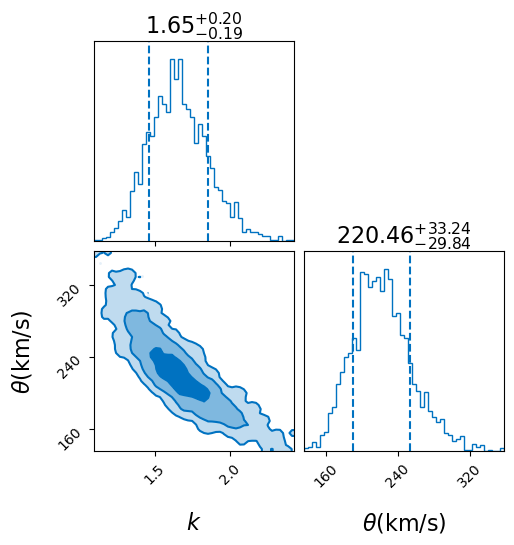

In [18]:
from scipy.special import beta
from scipy.special import gamma
def hyper_prior_gamma(dataset, k,theta):
    return (1 / (gamma(k)*theta**k)) * dataset['mu']**(k-1) *np.exp(-dataset['mu']/theta)

hp_priors_gamma = dict(k=Uniform(1,5, 'k',r'$k$'),
                theta=Uniform(10, 400, 'theta',r'$\theta$(km/s)') )

hyper_prior_gamma=hyper_prior_gamma

hp_likelihood_gamma = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_gamma,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_gamma =hp_priors_gamma
# And run sampler
result_gamma = run_sampler(
    likelihood=hp_likelihood_gamma, priors=hp_priors_gamma, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_gamma.plot_corner(title_fmt='.1f')

15:09 bilby INFO    : Running for label 'u_hype_27224', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
15:09 bilby INFO    : Analysis priors:
15:09 bilby INFO    : a=Uniform(minimum=10, maximum=300, name='a', latex_label='$a$', unit=None, boundary=None)
15:09 bilby INFO    : mlo=Uniform(minimum=1, maximum=50, name='mlow', latex_label='$m_{low}$', unit=None, boundary=None)
15:09 bilby INFO    : mup=LogUniform(minimum=50, maximum=10000.0, name='mup', latex_label='$m_{up}$', unit=None, boundary=None)
15:09 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
15:09 bilby INFO    : Analysis likelihood noise evidence: 0
15:09 bilby INFO    : Single likelihood evaluation took 1.773e-03 s
15:09 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 800, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600, 'first_update': None, 'rstate': None, 'queue_size'

1it [00:00, ?it/s]

15:10 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_27224_resume.pickle
15:10 bilby INFO    : Starting to close worker pool.
15:10 bilby INFO    : Finished closing worker pool.
15:10 bilby INFO    : Rejection sampling nested samples to obtain 2266 posterior samples
15:10 bilby INFO    : Sampling time: 0:01:01.221460
15:10 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
15:10 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


15:10 bilby INFO    : Summary of results:
nsamples: 2266
ln_noise_evidence:  0.000
ln_evidence: 87.061 +/-  0.074
ln_bayes_factor: 87.061 +/-  0.074



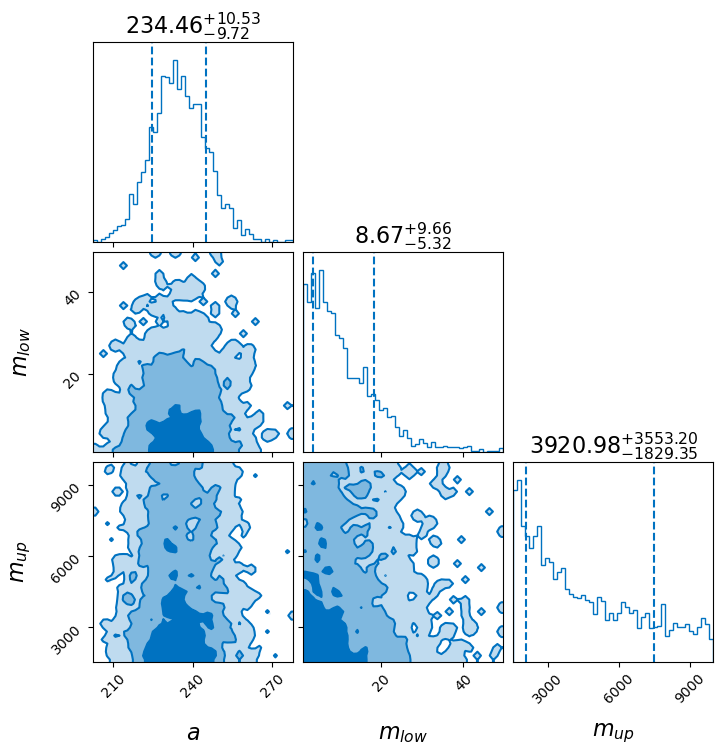

In [3]:
def _mb_cdf(v, a):
    """
    Maxwell-Boltzmann CDF for scale parameter a:
    F(v; a) = erf(v/(sqrt(2)*a)) - sqrt(2/pi) * (v/a) * exp(-v^2/(2 a^2))
    Works with v as scalar or numpy array (a scalar).
    """
    return erf(v / (np.sqrt(2) * a)) - np.sqrt(2.0 / np.pi) * (v / a) * np.exp(-v**2 / (2.0 * a**2))

def hyper_prior_MB(dataset, a, mlo, mup):
    x = np.asarray(dataset['mu'])
    data_mask = (x >= mlo) & (x <= mup)
    param_mask = (a > 0) & (mup > mlo) & (mlo >= 0)
    if not param_mask:
        return np.zeros_like(x, dtype=float)

    # MB pdf: f(v; a) = sqrt(2/pi) * v^2 / a^3 * exp(-v^2 / (2 a^2))
    # MB peak: v_peak=sqrt(2)*a
    pref = np.sqrt(2.0 / np.pi)
    pdf_vals = pref * x**2 / a**3 * np.exp(-x**2 / (2.0 * a**2))

    normalisingTerm = _mb_cdf(mup, a) - _mb_cdf(mlo, a)
    if normalisingTerm <= 0 or not np.isfinite(normalisingTerm):
        return np.zeros_like(x, dtype=float)

    out = np.zeros_like(x, dtype=float)
    out[data_mask] = pdf_vals[data_mask] / normalisingTerm
    return out

hp_priors_MB = dict(
    a=Uniform(10, 300, 'a', '$a$'),
    mlo=Uniform(1, 50, 'mlow', '$m_{low}$'),
    mup=LogUniform(50, 10000.0, 'mup', '$m_{up}$')
)

hyper_prior=hyper_prior_MB

hp_likelihood = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors =hp_priors_MB

# And run sampler
result = run_sampler(
    likelihood=hp_likelihood, priors=hp_priors, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result.plot_corner()


16:10 bilby INFO    : Running for label 'double_maxwell_hype_7734', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
16:10 bilby INFO    : Analysis priors:
16:10 bilby INFO    : sigma1=Uniform(minimum=1, maximum=200, name='sigma1', latex_label='$\\sigma_1$(km/s)', unit=None, boundary=None)
16:10 bilby INFO    : sigma2=Uniform(minimum=200, maximum=600, name='sigma2', latex_label='$\\sigma_2$(km/s)', unit=None, boundary=None)
16:10 bilby INFO    : alpha=Uniform(minimum=0.01, maximum=0.99, name='alpha', latex_label='$\\alpha$', unit=None, boundary=None)
16:10 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
16:10 bilby INFO    : Analysis likelihood noise evidence: 0
16:10 bilby INFO    : Single likelihood evaluation took 5.958e-03 s
16:10 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 800, 'bound': 'live', 'sample': 'act-walk', 'periodic': None, 'reflective': None, 'update_interval': 600

1it [00:00, ?it/s]

16:21 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/double_maxwell_hype_7734_resume.pickle
16:22 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/double_maxwell_hype_7734_resume.pickle
16:22 bilby INFO    : Starting to close worker pool.
16:22 bilby INFO    : Finished closing worker pool.
16:22 bilby INFO    : Rejection sampling nested samples to obtain 2606 posterior samples
16:22 bilby INFO    : Sampling time: 0:12:27.177411
16:22 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:22 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


16:22 bilby INFO    : Summary of results:
nsamples: 2606
ln_noise_evidence:  0.000
ln_evidence: 116.765 +/-  0.086
ln_bayes_factor: 116.765 +/-  0.086



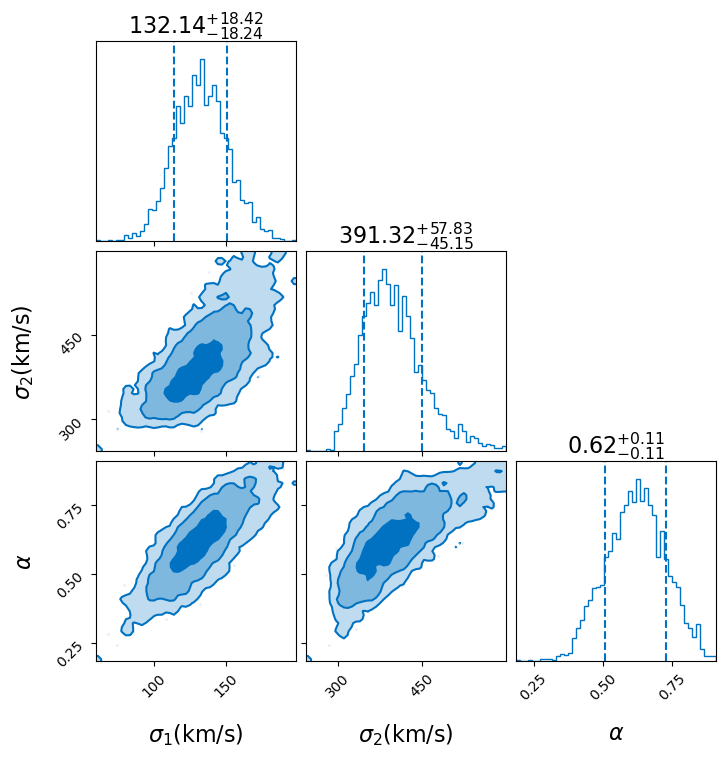

In [11]:

from scipy.stats import maxwell
from scipy.integrate import quad
def hyper_prior_double_maxwell(dataset,sigma1, sigma2, alpha):
    mup=10000
    mlo=1
    # 数据范围限制
    sigma_constraint = (mlo < sigma1) & (sigma1 < sigma2) & (sigma2 < mup)
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    
    # Maxwell PDF for the two components
    pdf1 = maxwell.pdf(dataset['mu'], scale=sigma1)
    pdf2 = maxwell.pdf(dataset['mu'], scale=sigma2)
    # Combined mixture PDF
    mixture_pdf = alpha * pdf1 + (1 - alpha) * pdf2
    # Apply range restriction
    log_likelihood = sigma_constraint*valid_range * mixture_pdf
    return log_likelihood

hp_priors_double_maxwell = dict(
    sigma1=Uniform(1, 200, 'sigma1', r'$\sigma_1$(km/s)'),
    sigma2=Uniform(200, 600, 'sigma2', r'$\sigma_2$(km/s)'),
    alpha=Uniform(0.01, 0.99, 'alpha', r'$\alpha$')
)

hyper_prior_double_maxwell = hyper_prior_double_maxwell

hp_likelihood_double_maxwell = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_double_maxwell,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_double_maxwell = hp_priors_double_maxwell

# 运行采样器
result_2M = run_sampler(
    likelihood=hp_likelihood_double_maxwell, priors=hp_priors_double_maxwell, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='double_maxwell_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

# 绘制角图
result_2M.plot_corner()

<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2903873/53600420.py:8: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_G_fixed_max_min= dict(mu=Uniform(1,300, 's_mu', '$\mu$'),
/tmp/ipykernel_2903873/53600420.py:9: SyntaxWarning: invalid escape sequence '\s'
  sigma=Uniform(100,600, 's_sigma', '$\sigma$'))
16:30 bilby INFO    : Running for label 'u_hype_70846', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
16:30 bilby INFO    : Analysis priors:
16:30 bilby INFO    : mu=Uniform(minimum=1, maximum=300, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
16:30 bilby INFO    : sigma=Uniform(minimum=100, maximum=600, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
16:30 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.Hyperpar

1it [00:00, ?it/s]

16:31 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_70846_resume.pickle
16:31 bilby INFO    : Starting to close worker pool.
16:31 bilby INFO    : Finished closing worker pool.
16:31 bilby INFO    : Rejection sampling nested samples to obtain 1901 posterior samples
16:31 bilby INFO    : Sampling time: 0:00:50.505355
16:31 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


16:31 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
16:31 bilby INFO    : Summary of results:
nsamples: 1901
ln_noise_evidence:  0.000
ln_evidence: 127.945 +/-  0.059
ln_bayes_factor: 127.945 +/-  0.059



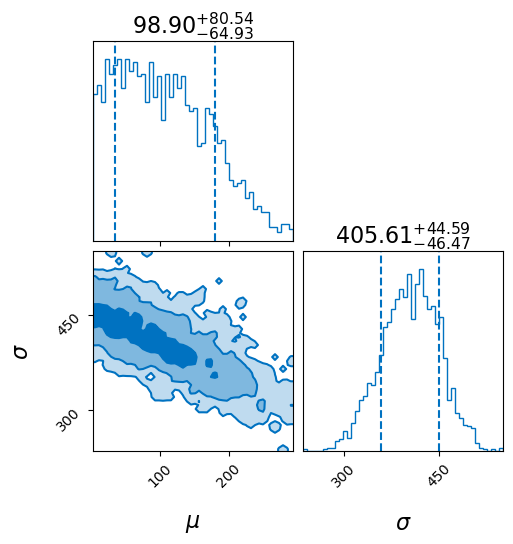

In [13]:
#begin Gaussian model with fixed upper and lower mass
def hyper_prior_G_fixed_max_min(dataset, mu, sigma):
    mup=10000
    mlo=1
    normalisingTerm = 0.5 * ( erf((mu-mlo)/(np.sqrt(2) * sigma)) -  erf((mu-mup)/(np.sqrt(2) * sigma)) )
    return ( ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))*((mu>mlo)&(mu<mup)) * (np.exp(- (dataset['mu'] - mu)**2 / (2 * sigma**2)) /\
        (2 * np.pi * sigma**2)**0.5) / normalisingTerm 
hp_priors_G_fixed_max_min= dict(mu=Uniform(1,300, 's_mu', '$\mu$'),
                 sigma=Uniform(100,600, 's_sigma', '$\sigma$'))
#end Gaussian with fixed upper and lower ma
#end Gaussian model 
hyper_prior_G=hyper_prior_G_fixed_max_min

hp_likelihood_G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_G =hp_priors_G_fixed_max_min

# And run sampler
result_G = run_sampler(
    likelihood=hp_likelihood_G, priors=hp_priors_G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_G.plot_corner()

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2981413/146054971.py:9: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_2G_fixed_max_min = dict(mu1=Uniform(1,300, 'mu1', '$\mu_1$'),
/tmp/ipykernel_2981413/146054971.py:10: SyntaxWarning: invalid escape sequence '\s'
  sigma1=LogUniform(1,1000, 'sigma1', '$\sigma_1$'),
/tmp/ipykernel_2981413/146054971.py:11: SyntaxWarning: invalid escape sequence '\m'
  mu2=LogUniform(1, 1000, 'mu2', '$\mu_2$'),
/tmp/ipykernel_2981413/146054971.py:12: SyntaxWarning: invalid escape sequence '\s'
  sigma2=LogUniform(1, 1000, 'sigma2', '$\sigma_2$'),
15:54 bilby INFO    : Running for

1it [00:00, ?it/s]

16:07 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
16:18 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
16:33 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
16:50 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
17:07 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
17:19 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
17:32 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_48496_resume.pickle
17:47 bilby INFO    : Written checkpoint file /home/lz/work/pu

20:20 bilby INFO    : Rejection sampling nested samples to obtain 3185 posterior samples
20:20 bilby INFO    : Sampling time: 4:25:37.410728
20:20 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
20:20 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
20:20 bilby INFO    : Summary of results:
nsamples: 3185
ln_noise_evidence:  0.000
ln_evidence: 128.150 +/-  0.099
ln_bayes_factor: 128.150 +/-  0.099



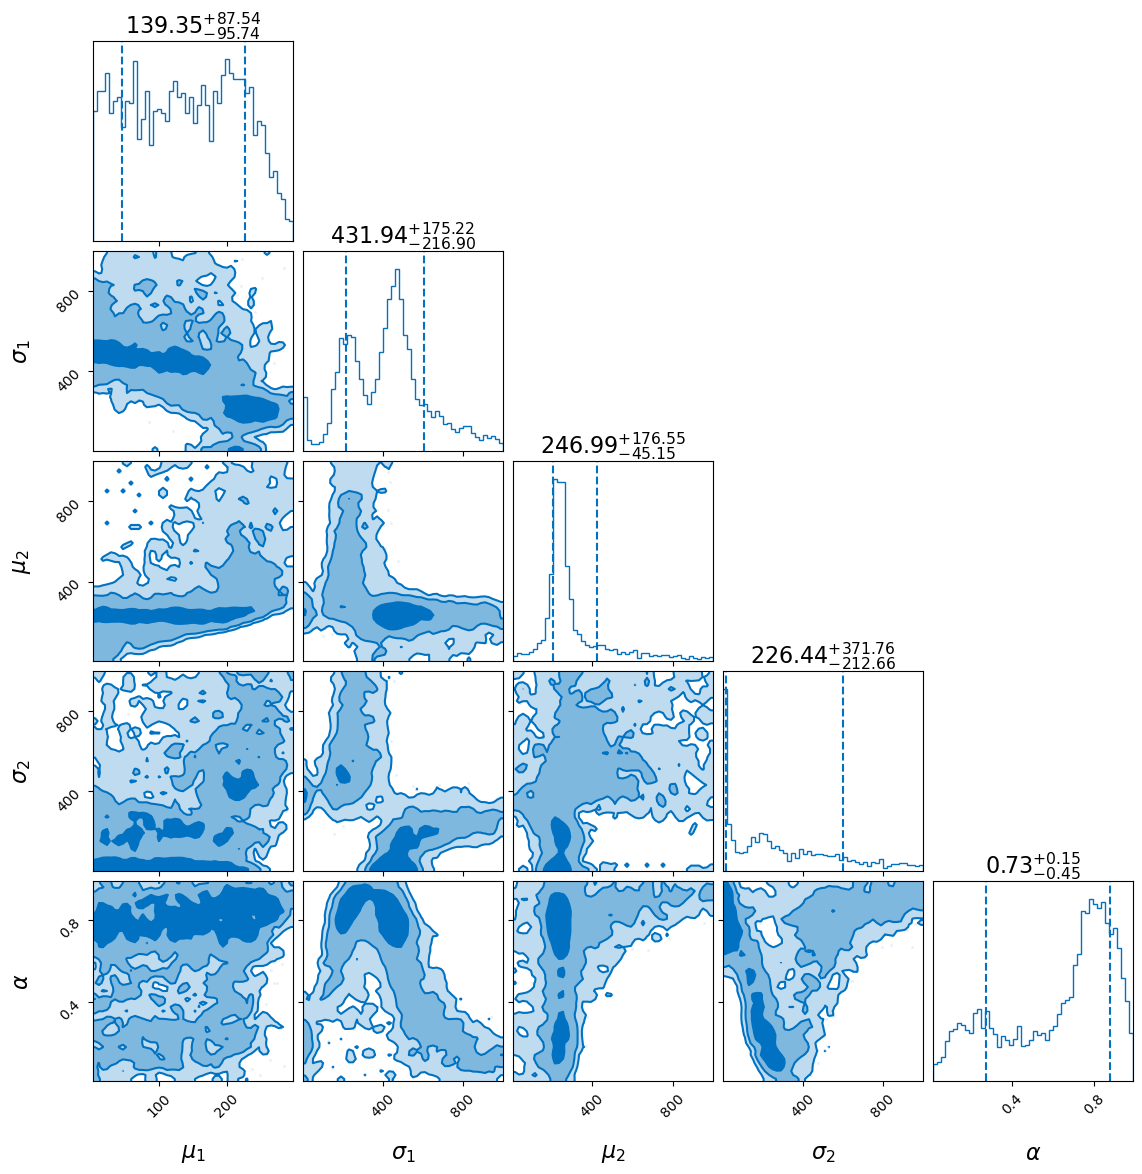

In [17]:
def hyper_prior_2G_fixed_max_min(dataset, mu1, sigma1,mu2,sigma2,alpha):
    mup=10000
    mlo=1
    normalisingTerm1 = 0.5 * ( erf((mu1-mlo)/(np.sqrt(2) * sigma1)) -  erf((mu1-mup)/(np.sqrt(2) * sigma1)) )
    normalisingTerm2 = 0.5 * ( erf((mu2-mlo)/(np.sqrt(2) * sigma2)) -  erf((mu2-mup)/(np.sqrt(2) * sigma2)) )
    return ((mu2 < mup ) & (mu1 > mlo) & (mu1 < mu2)  & ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) *\
        ( (( alpha*(np.exp(- (dataset['mu'] - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)) /normalisingTerm1) +\
        (1-alpha)*( ((np.exp(- (dataset['mu'] - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5) ) / normalisingTerm2) )
hp_priors_2G_fixed_max_min = dict(mu1=Uniform(1,300, 'mu1', '$\mu_1$'),
                sigma1=LogUniform(1,1000, 'sigma1', '$\sigma_1$'),
                mu2=LogUniform(1, 1000, 'mu2', '$\mu_2$'),
                sigma2=LogUniform(1, 1000, 'sigma2', '$\sigma_2$'),
                alpha=Uniform(0.01, 0.99, 'alpha', '$\\alpha$'))
#end two-Gausssian model with fixed lower and upper mass
hyper_prior_2G=hyper_prior_2G_fixed_max_min
hp_likelihood_2G = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_2G,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_2G =hp_priors_2G_fixed_max_min

# And run sampler
result_2G = run_sampler(
    likelihood=hp_likelihood_2G, priors=hp_priors_2G, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_2G.plot_corner()

20:39 bilby INFO    : Running for label 'u_hype_56621', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
20:39 bilby INFO    : Analysis priors:
20:39 bilby INFO    : mu=Uniform(minimum=1, maximum=500, name='mlo', latex_label='$\\rm{\\mu}$', unit=None, boundary=None)
20:39 bilby INFO    : sigma=Uniform(minimum=1, maximum=500, name='sigma', latex_label='$\\rm{\\sigma}$', unit=None, boundary=None)
20:39 bilby INFO    : nu=LogUniform(minimum=0.1, maximum=300, name='nu', latex_label='$\\rm{\\nu}$', unit=None, boundary=None)
20:39 bilby INFO    : tau=Uniform(minimum=2.01, maximum=400, name='tau', latex_label='$\\rm{\\tau}$', unit=None, boundary=None)
20:39 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
20:39 bilby INFO    : Analysis likelihood noise evidence: 0
20:39 bilby INFO    : Single likelihood evaluation took 1.352e-02 s
20:39 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 800, 'bo

1it [00:00, ?it/s]

21:17 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
21:29 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
21:51 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
22:05 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
22:16 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
22:40 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
23:26 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_56621_resume.pickle
00:13 bilby INFO    : Written checkpoint file /home/lz/work/pu

07:17 bilby INFO    : Rejection sampling nested samples to obtain 2754 posterior samples
07:17 bilby INFO    : Sampling time: 10:37:26.780108
07:17 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
07:17 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
07:17 bilby INFO    : Summary of results:
nsamples: 2754
ln_noise_evidence:  0.000
ln_evidence: 124.647 +/-  0.107
ln_bayes_factor: 124.647 +/-  0.107



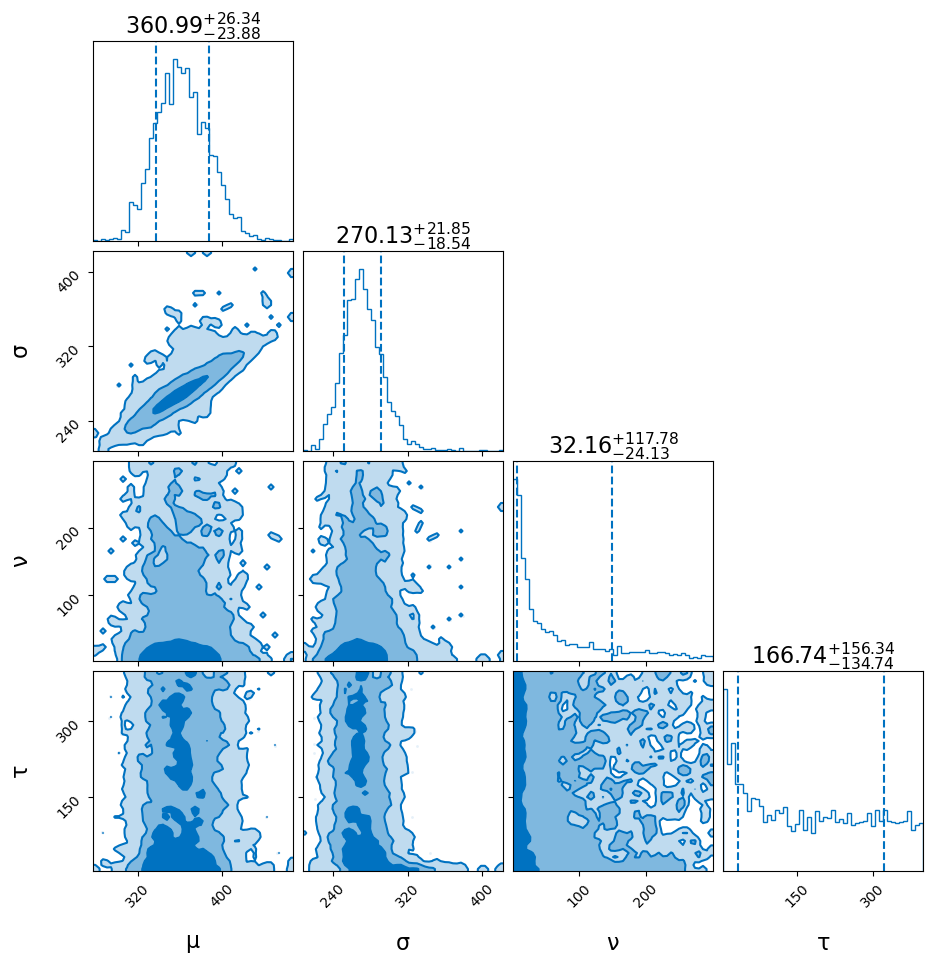

In [ ]:
#begin SST
from scipy.special import beta
def hyper_prior_sst(dataset, mu,sigma,nu,tau):
        c = 2 * nu * ((1 + nu ** 2) *
                                beta(0.5, tau / 2) *
                                tau ** 0.5) ** -1
        m = ((2 * tau ** 0.5) * (nu - nu ** -1)) / (
                (tau - 1) * beta(0.5, 0.5 * tau))
        s2 = ((tau / (tau - 2)) * (
                nu ** 2 + nu ** -2 - 1) - m ** 2)
        mu_0 = mu - (sigma * m / np.sqrt(s2))
        sigma_0 = sigma / np.sqrt(s2)
        z = (dataset['mu'] - mu_0) / sigma_0
        p = np.where(dataset['mu'] < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p

hp_priors_sst = dict(mu=Uniform(1, 500, 'mlo',r'$\rm{\mu}$'),
                sigma=Uniform(1, 500, 'sigma',r'$\rm{\sigma}$'),
                nu=LogUniform(0.01,300,'nu',r'$\rm{\nu}$'),
                tau=Uniform(2.01,400,'tau',r'$\rm{\tau}$') )
#end SST
hyper_prior_sst=hyper_prior_sst
hp_likelihood_sst = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_sst,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_sst =hp_priors_sst

# And run sampler
result_sst = run_sampler(
    likelihood=hp_likelihood_sst, priors=hp_priors_sst, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_sst.plot_corner()

<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2981413/956953844.py:4: SyntaxWarning: invalid escape sequence '\m'
  hp_priors_lognorm = dict(s_mu=Uniform(5, 6, 's_mu', '$\mu$'),
/tmp/ipykernel_2981413/956953844.py:5: SyntaxWarning: invalid escape sequence '\s'
  s_sigma=Uniform(0.5, 1.5, 's_sigma', '$\sigma$') )
10:09 bilby INFO    : Running for label 'u_hype_46098', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
10:09 bilby INFO    : Analysis priors:
10:09 bilby INFO    : s_mu=Uniform(minimum=5, maximum=6, name='s_mu', latex_label='$\\mu$', unit=None, boundary=None)
10:09 bilby INFO    : s_sigma=Uniform(minimum=0.5, maximum=1.5, name='s_sigma', latex_label='$\\sigma$', unit=None, boundary=None)
10:09 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.Hyperp

1it [00:00, ?it/s]

10:11 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_46098_resume.pickle
10:11 bilby INFO    : Starting to close worker pool.
10:12 bilby INFO    : Finished closing worker pool.
10:12 bilby INFO    : Rejection sampling nested samples to obtain 2176 posterior samples
10:12 bilby INFO    : Sampling time: 0:02:11.197193
10:12 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
10:12 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


10:12 bilby INFO    : Summary of results:
nsamples: 2176
ln_noise_evidence:  0.000
ln_evidence: 123.809 +/-  0.074
ln_bayes_factor: 123.809 +/-  0.074



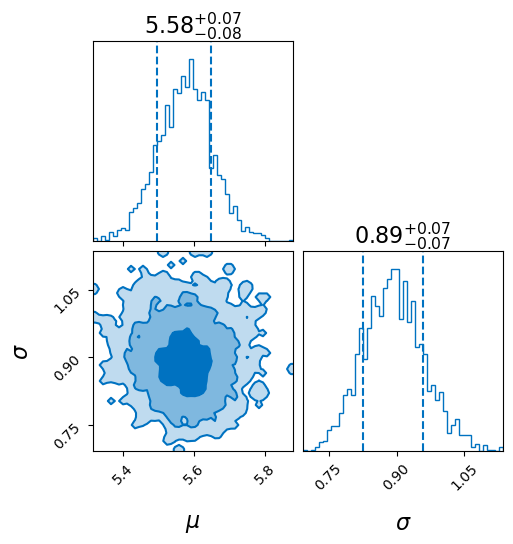

In [4]:
def hyper_prior_lognorm(dataset, s_mu, s_sigma):
    return np.exp(- (np.log(dataset['mu']) - s_mu)**2 / (2 * s_sigma**2)) /\
        (2 * np.pi * s_sigma**2)**0.5/(dataset['mu'])
hp_priors_lognorm = dict(s_mu=Uniform(5, 6, 's_mu', '$\mu$'),
                 s_sigma=Uniform(0.5, 1.5, 's_sigma', '$\sigma$') )

hyper_prior_lognorm=hyper_prior_lognorm

hp_likelihood_lognorm = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_lognorm,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_lognorm =hp_priors_lognorm

# And run sampler
result_lognorm = run_sampler(
    likelihood=hp_likelihood_lognorm, priors=hp_priors_lognorm, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_lognorm.plot_corner()

11:22 bilby INFO    : Running for label 'u_hype_73128', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
11:22 bilby INFO    : Analysis priors:
11:22 bilby INFO    : mlo=Uniform(minimum=1, maximum=100, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
11:22 bilby INFO    : mup=Uniform(minimum=100, maximum=10000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
11:22 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
11:22 bilby INFO    : Analysis likelihood noise evidence: 0
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
11:22 bilby INFO    : Single likelihood evaluation took 5.154e-04 s
11:22 bilby INFO    : Using sampler Dynesty with kwargs {'nlive': 800, 'bound': 'live', 'sample': 'act-walk', 'perio

1it [00:00, ?it/s]

11:27 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/u_hype_73128_resume.pickle
11:27 bilby INFO    : Starting to close worker pool.
11:27 bilby INFO    : Finished closing worker pool.
11:27 bilby INFO    : Rejection sampling nested samples to obtain 2866 posterior samples
11:27 bilby INFO    : Sampling time: 0:04:33.907788
11:27 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 


11:27 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
11:27 bilby INFO    : Summary of results:
nsamples: 2866
ln_noise_evidence:  0.000
ln_evidence: 99.201 +/-  0.105
ln_bayes_factor: 99.201 +/-  0.105



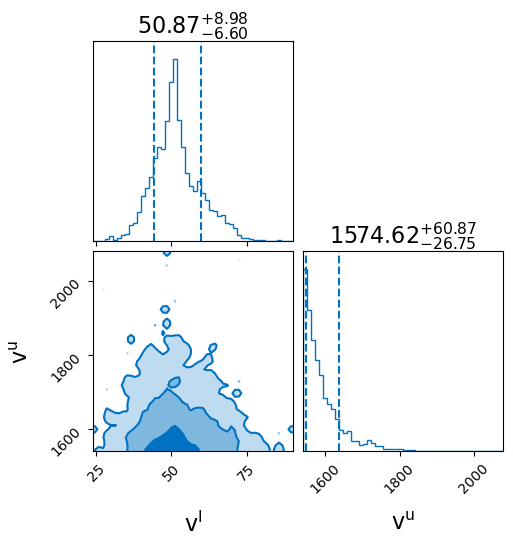

In [9]:
def hyper_prior_logu(dataset,mlo,mup):
    return (( dataset['mu'] >= mlo) & (dataset['mu'] <= mup))/( dataset['mu'] * np.log(mup / mlo) )

hp_priors_logu = dict(mlo=Uniform(1, 100, 'mlo',r'$\rm{v^l}$'),
                mup=Uniform(100, 10000, 'mup',r'$\rm{v^u}$'))
#end log-uniform
hyper_prior_logu=hyper_prior_logu

hp_likelihood_logu = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_logu,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_logu =hp_priors_logu

# And run sampler
result_logu = run_sampler(
    likelihood=hp_likelihood_logu, priors=hp_priors_logu, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='u_hype_{}'.format(np.random.randint(1,88888)),
    verbose=True, clean=True,npool=npool)
result_logu.plot_corner()

11:48 bilby INFO    : Running for label 'exponential_hype_87344', output will be saved to '/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir'
11:48 bilby INFO    : Analysis priors:
11:48 bilby INFO    : lam=LogUniform(minimum=0.002, maximum=0.004, name='lam', latex_label='$\\lambda$', unit=None, boundary=None)
11:48 bilby INFO    : mlo=Uniform(minimum=1, maximum=10, name='mlo', latex_label='$\\rm{v^l}$', unit=None, boundary=None)
11:48 bilby INFO    : mup=LogUniform(minimum=10, maximum=10000, name='mup', latex_label='$\\rm{v^u}$', unit=None, boundary=None)
11:48 bilby INFO    : Analysis likelihood class: <class 'bilby.hyper.likelihood.HyperparameterLikelihood'>
11:48 bilby INFO    : Analysis likelihood noise evidence: 0
/home/lz/miniconda3/envs/lz/lib/python3.13/site-packages/bilby/hyper/likelihood.py:64: RuntimeWarning: divide by zero encountered in log
  log_l = np.sum(np.log(np.sum(self.hyper_prior.prob(self.data, **parameters) /
11:48 bilby INFO    : Single likelihood ev

1it [00:00, ?it/s]

11:54 bilby INFO    : Written checkpoint file /home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/exponential_hype_87344_resume.pickle
11:54 bilby INFO    : Starting to close worker pool.
11:54 bilby INFO    : Finished closing worker pool.


11:54 bilby INFO    : Rejection sampling nested samples to obtain 2113 posterior samples
11:54 bilby INFO    : Sampling time: 0:05:36.297047
11:54 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
11:54 bilby WARNING : Result.save_to_file called with extension=True. This will default to json, and ignore the extension from the filename. This behaviour is deprecated and will be removed. 
11:55 bilby INFO    : Summary of results:
nsamples: 2113
ln_noise_evidence:  0.000
ln_evidence: 123.125 +/-  0.047
ln_bayes_factor: 123.125 +/-  0.047



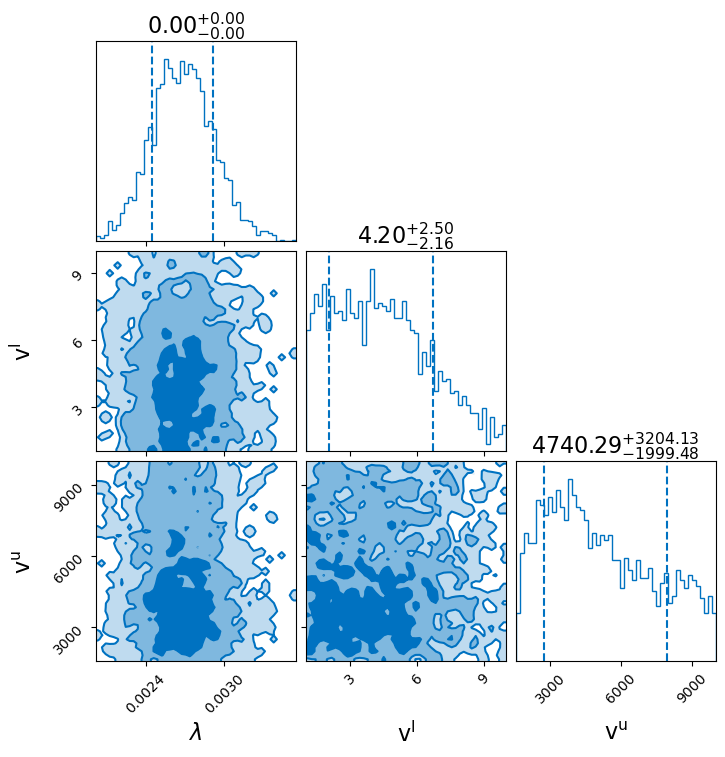

In [ ]:
from scipy.stats import expon

def hyper_prior_exponential(dataset, mup, mlo, lam):
    valid_range = (dataset['mu'] >= mlo) & (dataset['mu'] <= mup)
    # Exponential PDF
    pdf_values = expon.pdf(dataset['mu'], scale=1/lam)
    # 限制范围外的概率为 0
    log_likelihood = valid_range * pdf_values
    return log_likelihood

hp_priors_exponential = dict(
    lam=Uniform(0.002, 0.004, 'lam', r'$\lambda$'),  # 速率参数范围
    mlo=Uniform(1, 10, 'mlo', r'$\rm{v^l}$'),  # 下限范围
    mup=LogUniform(10, 10000, 'mup', r'$\rm{v^u}$')    # 上限范围
)

hyper_prior_exponential = hyper_prior_exponential

hp_likelihood_exponential = HyperparameterLikelihood(
    posteriors=samples, hyper_prior=hyper_prior_exponential,
    sampling_prior=run_prior, log_evidences=0, max_samples=mx)

hp_priors_exponential = hp_priors_exponential

# 运行采样器
result_exponential = run_sampler(
    likelihood=hp_likelihood_exponential, priors=hp_priors_exponential, sampler='dynesty', nlive=nlive,
    use_ratio=False, outdir=outdir, label='exponential_hype_{}'.format(np.random.randint(1, 88888)),
    verbose=True, clean=True, npool=npool)

# 绘制角图
result_exponential.plot_corner()

In [12]:
import bilby
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
file_exponential='/home/lz/work/pulsar_kick_velocity/mnt/BuffaloB/lz/hy_outdir/exponential_hype_87344_result.json'
result_exponential = bilby.result.read_in_result(file_exponential)
posterior_exponential=result_exponential.posterior
print(posterior_exponential)

           lam       mlo          mup  log_likelihood  log_prior
0     0.002018  7.590204  2619.605039      118.418693  -5.428537
1     0.003548  5.426650  4381.194487      119.084033  -6.507127
2     0.002216  5.541503  1637.923832      119.846919  -5.052357
3     0.002238  4.483749  1558.532176      119.969641  -5.012521
4     0.002138  1.793571  1902.641077      120.075553  -5.166532
...        ...       ...          ...             ...        ...
2108  0.002670  1.543983  5550.668034      124.866009  -6.459184
2109  0.002670  1.972211  5568.348399      124.866023  -6.462430
2110  0.002672  1.815264  5576.446511      124.866028  -6.464735
2111  0.002672  2.175241  5558.832153      124.866030  -6.461436
2112  0.002676  1.923318  9534.648214      124.866081  -7.002635

[2113 rows x 5 columns]


1σ 中心区间: (0.0024, 0.002916)
0.0026764265354022893


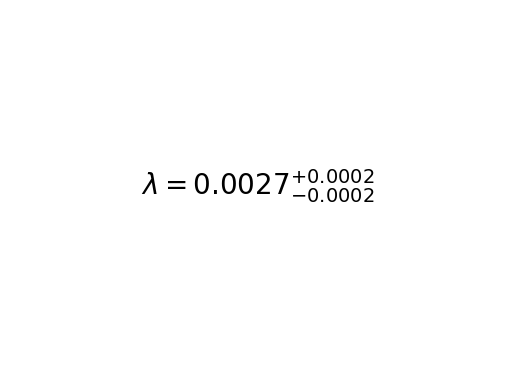

In [13]:

# 计算中心区间
center_interval = np.percentile(posterior_exponential['lam'], [16, 84])
print(f"1σ 中心区间: ({center_interval[0]:.4f}, {center_interval[1]:.4})")
median_lam=np.median(posterior_exponential['lam'])
print(median_lam)
alpha = center_interval[1] - median_lam
beta = median_lam - center_interval[0]

latex_str = f"$\\lambda = {median_lam:.4f} ^{{+{alpha:.4f}}} _{{-{beta:.4f}}}$"
# 显示LaTeX公式
plt.text(0.5, 0.5, latex_str, fontsize=20, ha='center')
plt.axis('off')  # 关闭坐标轴
plt.show()